ライブラリインポート

In [1]:
import pandas as pd
import numpy as np

#import pycaret

#setup関数をimport
#from pycaret.regression import setup

#compare_models関数は、ライブラリ内のすべてのモデルを使って訓練を行い、スコアを評価する。
#回帰問題なので'refression'を指定
#from pycaret.regression import compare_models

#models関数により、すべての使用可能な機械学習モデルを確認できる。
#from pycaret.regression import models

#ceate_model関数:「交差検証」を用いて個別のモデルの訓練と評価を行う。  
#from pycaret.regression import create_model

#tune_model関数を用いて、ハイパーパラメータを最適化する。
#from pycaret.regression import tune_model

#plot_model関数を使い、各特徴量の重要度をプロットする、
#from pycaret.regression import plot_model

#finalize_model関数により、すべての訓練データを使ってモデルを訓練し、本番用のモデルを作成できるようにする。
#from pycaret.regression import finalize_model

#from pycaret.regression import predict_model

import lightgbm as lgb
from sklearn import metrics
from scipy.stats import rankdata
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.simplefilter('ignore', FutureWarning)

import re
import pickle
import seaborn as sns
import lightgbm as lgb
#import japanize_matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

import copy

import statsmodels.api as sm

# 検証４  
## SARIMAX  
SARIMA（季節 自己回帰 和分 移動平均モデル） ...S(データに周期性がある) + ARIMA  
SARIMAX ...SARIMA + 説明変数

SARIMAは日付ごとなど、一個一個分かれてないと予測できない。  
今回は使えない。

# 検証5

### Deep learning  
## GRU

目的変数・・・利用者('cnt')  
説明変数・・・hr,workday,曜日('weekday')、温度('temp')、体感温度('atemp')、天気('weathersit')    
cntと相関関係のある変数を使う

In [2]:
#前処理

#trainデータ処理
train_df = pd.read_table('train.tsv')
#One-Hot Encoding
train_df_one_hot_encoded = pd.get_dummies(train_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
train_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
train_df_one_hot_encoded.loc[train_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1
# 結果の件数を確認する
#train_df_one_hot_encoded['weekday2'].value_counts()
# id2500以前は、傾向が違うため、カット(運用開始など？)
train_df_one_hot_encoded = train_df_one_hot_encoded[train_df_one_hot_encoded['id'] > 2500]


#testデータ処理
test_df = pd.read_table('test.tsv')
#One-Hot Encoding
test_df_one_hot_encoded = pd.get_dummies(test_df,columns=['weathersit'])
#曜日の'weekday'を土日(0)と平日(1)の2値データする。
#新しい変数'weekday2'を作って、全て0(zero)を入れる
test_df_one_hot_encoded['weekday2'] = 0
#平日を1にしたいので、1にするコードを用意する
test_df_one_hot_encoded.loc[test_df_one_hot_encoded['weekday'].isin(list(range(1,6))),'weekday2']=1


In [3]:
train_df_one_hot_encoded['weekday2'].value_counts()

1    4407
0    1738
Name: weekday2, dtype: int64

In [4]:
train_df_one_hot_encoded.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,temp,atemp,hum,windspeed,cnt,weathersit_1,weathersit_2,weathersit_3,weathersit_4,weekday2
2500,2501,2011-04-19,2,0,4,2,0,2,1,0.46,0.4545,0.67,0.2836,13,1,0,0,0,1
2501,2502,2011-04-19,2,0,4,3,0,2,1,0.48,0.4697,0.63,0.2239,3,1,0,0,0,1
2502,2503,2011-04-19,2,0,4,4,0,2,1,0.46,0.4545,0.67,0.0896,5,1,0,0,0,1
2503,2504,2011-04-19,2,0,4,5,0,2,1,0.46,0.4545,0.72,0.1940,18,0,1,0,0,1
2504,2505,2011-04-19,2,0,4,6,0,2,1,0.48,0.4697,0.67,0.0000,65,0,1,0,0,1


必要なモジュールをインポート

In [5]:
import matplotlib.pyplot as plt
#tensorflowを用いる。
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Input, BatchNormalization,LSTM,GRU
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

説明変数xと目的変数yを準備する。  

In [158]:
#必要な説明変数だけをとりだす
train_df_x = train_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
train_df_y = train_df_one_hot_encoded['cnt']
train_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
2500,2,1,1,0.46,0.4545,1,0,0
2501,3,1,1,0.48,0.4697,1,0,0
2502,4,1,1,0.46,0.4545,1,0,0
2503,5,1,1,0.46,0.4545,0,1,0
2504,6,1,1,0.48,0.4697,0,1,0


In [159]:
# defaultはtrain dataが75%、test dataが25%に分割されます。
# また時系列のデータなので、shuffleをFalseにします。
train_X, test_X, train_y, test_y = train_test_split(train_df_x, train_df_y, random_state=42, shuffle=False)

# input_dimに説明変数の数を入れます。
# Denseで層を設定します。
model = Sequential()
model.add(Dense(256, input_dim=8, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) #128のNordを50%落とす
model.add(Dense(1))

# 損失関数にmse、最適化関数にadamを採用
model.compile(loss='mse', optimizer='adam')

# モデルを学習させます
# epochsは学習回数24回(1時間ごとのデータで、24回で一日分のため)
#データ数(6483) x 学習回数
# batch_size データ数(6483)を細かく分ける
train_model = model.fit(train_X, train_y, epochs= 60, batch_size= 24, verbose=1, validation_data=(test_X, test_y))

Epoch 1/60
192/192 [==============================] - 1s 3ms/step - loss: 24023.7266 - val_loss: 15386.7480
Epoch 2/60
192/192 [==============================] - 0s 2ms/step - loss: 17070.4160 - val_loss: 14252.9111
Epoch 3/60
192/192 [==============================] - 0s 2ms/step - loss: 16554.1055 - val_loss: 14908.2822
Epoch 4/60
192/192 [==============================] - 0s 2ms/step - loss: 16440.3828 - val_loss: 12963.1143
Epoch 5/60
192/192 [==============================] - 0s 2ms/step - loss: 16084.5576 - val_loss: 13000.0713
Epoch 6/60
192/192 [==============================] - 0s 2ms/step - loss: 15554.5312 - val_loss: 11542.6846
Epoch 7/60
192/192 [==============================] - 0s 2ms/step - loss: 15315.5381 - val_loss: 10713.5918
Epoch 8/60
192/192 [==============================] - 0s 3ms/step - loss: 14699.9355 - val_loss: 11082.4219
Epoch 9/60
192/192 [==============================] - 0s 2ms/step - loss: 14448.4727 - val_loss: 10079.3633
Epoch 10/60
192/192 [=======

49/49 [==============================] - 0s 2ms/step
REG RMSE : 86.83


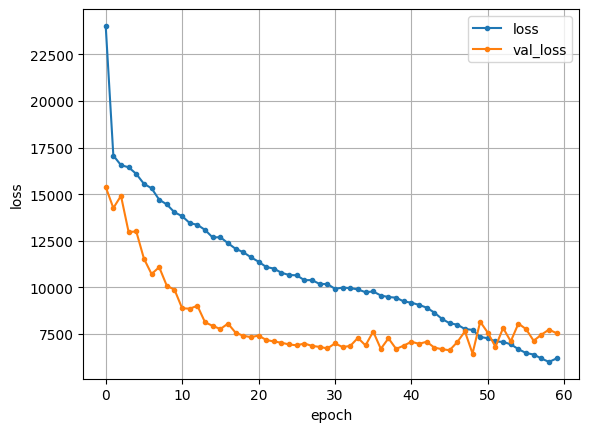

In [160]:
# 予測値を出力
y_pred = model.predict(test_X)

# 二乗誤差を出力
mse= mean_squared_error(test_y, y_pred)
print("REG RMSE : %.2f" % (mse** 0.5))

# epoch毎の予測値の正解データとの誤差を表しています
# バリデーションデータのみ誤差が大きい場合、過学習を起こしています

loss=train_model.history['loss']
val_loss=train_model.history['val_loss']
epochs=len(loss)

plt.plot(range(epochs), loss, marker = '.', label = 'loss')
plt.plot(range(epochs), val_loss, marker = '.', label = 'val_loss')
plt.legend(loc = 'best')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch20あたりからlossが7500あたりで停滞  
val_lossが徐々に下がっていて、なかなか良いモデル。

In [165]:
from sklearn.metrics import mean_squared_error
# RMSE計算
rmse = np.sqrt(mean_squared_error(test_y, y_pred))
print('RMSE : {:.3f}'.format(rmse))


RMSE : 86.832


わるく無さそう。

In [166]:
#testデータの必要な変数だけをとりだす
test_df_x = test_df_one_hot_encoded[['hr','workingday','weekday2','temp','atemp','weathersit_1','weathersit_2','weathersit_3']]
test_df_x.head()

,hr,workingday,weekday2,temp,atemp,weathersit_1,weathersit_2,weathersit_3
0,0,0,0,0.36,0.3788,1,0,0
1,1,0,0,0.36,0.3485,1,0,0
2,2,0,0,0.32,0.3485,1,0,0
3,3,0,0,0.30,0.3333,1,0,0
4,4,0,0,0.28,0.3030,1,0,0


In [167]:
test_df_x.shape

(8734, 8)

In [168]:
# test dataにモデルを適用する
Y_test_pred = model.predict(test_df_x) #X_testデータを使って予測する

273/273 [==============================] - 0s 2ms/step


In [169]:
Y_test_pred

array([[92.98216 ],
       [62.593594],
       [34.43942 ],
       ...,
       [93.07214 ],
       [76.33465 ],
       [62.49991 ]], dtype=float32)

### 提出ファイルの作成

In [170]:
Y_test_pred.shape,test_df.shape

((8734, 1), (8734, 14))

In [171]:
sub = test_df.copy()
sub['cnt'] = Y_test_pred
sub.head(5)

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,8646,2012-01-01,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000,92.982162
1,8647,2012-01-01,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343,62.593594
2,8648,2012-01-01,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000,34.439419
3,8649,2012-01-01,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000,15.353641
4,8650,2012-01-01,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896,8.348648


In [172]:
# 提出ファイル
sub[['id','cnt']].to_csv('sample_submit_03.csv', index=False, header = False)

In [173]:
sample_submit_03 = pd.read_csv('sample_submit_03.csv')
sample_submit_03.head(5)

,8646,92.98216
0,8647,62.593594
1,8648,34.439420
2,8649,15.353641
3,8650,8.348648
4,8651,7.925747


### 評価  
RMSE  ?(125/1246位)  
精度は高いとは言えない、  
特徴量を加えたり、別の学習モデルやアンサンブル学習などいろいろ出来そう。

# やること  
ディープラーニングのRNN,GRU,LSTMの違いについて学習  
GRU,LSTMの実装。  
結局XGboostが強いと思われるので、ここを調べる。